# Instruction to lab work # 1

> Student name    - Danylo

> Student surname - Hretskyi

> Group           - CS-31


# Task description

### Overall work description

The work will contain 2 main parts:
1. In the first part you'll build intuition behind using various regression models using only artificially generated (with noise & outliers) data. I've generated 2 options with `f(x) = A*sin(x) + B` and `f(x) = a*x + b` functions. (you free to add more complex functions (even more dimensional).
2. In the second part you'll solve regression problem on the real data.

Do NOT forget to change your `STUDENT_NO` -- this variable defines random state (it just makes experimental data for every one slighty different).

Do NOT forget to set you contact data in the top cell.


### I. Experiments on artificially generated data:

1. Manually tune linear model by changing `a` and `b` weights of it. Observe position of the line and values of loss function.
2. **More advanced task** (+2 point): modify my code to work with more complex functions as regression models (linear, polynomial, sin, cos, and their combination). Feel free to use as complex function as you could found. Generate some random non-linear data and use your function to manually adjust its weights.
3. Play with default regression methods from `sklearn` library on non-linear data. Search, llm-prompt information on each model to understand how to make the model fit the data without overfitting.


### II. Experiments on real data. (you can keep it in this notebook or in a separate one).

1. Choose any DataSet you like for you experiments (if you've chosen the same, consider that work must differ, otherwise both students will get 0 points for work).
2. Choose the top-3 methods (from `sklearn` library, or you can use other libraries (like `xgboost`) from the previous part.
2. Solve the regression problem in the same manner, as you used for.
    1. Load the data
    2. Do data visualization: correlation, feature distribution, etc.
    3. Do data analysis
    4. Do data correction
    5. Prepare data on usage with ML model: train, validation if necessary, test split; data convertion (to fix distribution or change data type to numeric); remove outliers.
    6. Tune hyperparameters of your model to get the best one.
    7. Train & test the final version of the model. Do conclusion.
3. Your main goal is tune hyperparameters of the chosen models.
4. Examples and template you can find in `ML_basic_course/lab_works/lab2/lab_2_example_plus_task.ipynb`. Or in [my GitHub repo's folder](https://github.com/VolDonets/ML_basics_course/tree/master/lab_works/lab_2)
5. Use that notebook as template, but remember your main goal is to tune hyperparameters of chosen models.

### III. Important.

1. Students, who solved the problem in a single code cell will get 0 points for your work. It's hard to work with your messy code, we have limited time. Use this notebook as your template, create as many cells as you need. Also you can conduct experiments in .py files but in that case prepare normal report.
2. Experiments means you have multiple cells with EXPERIMENTS and your CONCLUSION after that.
3. You can have multiple notebooks if you need, but name it correctly and add `ReadMe.md`.


## Proposition of the real data for experiments

7. [California House Price](https://www.kaggle.com/datasets/shibumohapatra/house-price)


In [63]:
STUDENT_NO = 3

# Import dependencies

In [64]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns

# Helping functions

In [65]:
def generate_regression_data(
    n_samples=50,
    n_features=1,
    mode='linear',
    noise=2.0,
    n_outliers=5,
    random_seed=42,
    return_coef=False
):
    """
    Generates data for regression tasks, compatible with scikit-learn.

    :param n_samples: The total number of data points to generate.
    :param n_features: The number of features for the dataset.
    :param mode: The underlying pattern of the data. Can be 'linear' or 'nonlinear'.
    :param noise: The standard deviation of Gaussian noise added to the y-values.
    :param n_outliers: The number of outlier points to add to the dataset.
    :param random_seed: A seed for the random number generator for reproducibility.
    :param return_coef: If True, also returns the true coefficients of the generative model.
    :returns: A tuple (X, y) or (X, y, coefficients) if return_coef is True.
              X is the feature matrix of shape (n_samples, n_features).
              y is the target vector of shape (n_samples,).
              coefficients is a dictionary with 'weights' and 'intercept'.
    """
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features) * 10 - 5

    true_intercept = 0
    true_weights = np.zeros(n_features)

    if mode == 'linear':
        true_intercept = np.random.uniform(-3, 3)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = np.dot(X, true_weights) + true_intercept
    elif mode == 'nonlinear':
        if n_features < 1:
            raise ValueError("Nonlinear mode requires at least 1 feature.")
        true_intercept = np.random.uniform(-15, 15)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = true_weights[0] * 20 * np.sin(X[:, 0]*1.5) + true_intercept
        if n_features > 1:
             y_true += np.dot(X[:, 1:], true_weights[1:])
    else:
        raise ValueError("Mode must be either 'linear' or 'nonlinear'")

    y = y_true + np.random.normal(scale=noise, size=n_samples)

    if n_outliers > 0:
        outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
        outlier_offset = (np.random.rand(n_outliers) - 0.5) * 30 * (noise + 1)
        y[outlier_indices] += outlier_offset

    if return_coef:
        coefficients = {'weights': true_weights, 'intercept': true_intercept}
        return X, y, coefficients
    else:
        return X, y

In [66]:
def plot_regression_model(
    X,
    y,
    weights=None,
    intercept=None,
    title="Regression Model Visualization",
):
    """
    Visualizes regression data and model performance.

    If the data has one feature, it plots the data points and the regression line.
    If the data has multiple features, it plots the model's predicted vs. actual values.

    :param X: The feature matrix, shape (n_samples, n_features).
    :param y: The target vector, shape (n_samples,).
    :param weights: The model's feature weights (coefficients).
    :param intercept: The model's intercept.
    :param title: The title for the plot.
    :returns: None. Displays a matplotlib plot.
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n_features = X.shape[1]
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    model_provided = weights is not None and intercept is not None

    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.7, edgecolors='k', label='Data Points')
        if model_provided:
            x_line = np.linspace(X.min(), X.max(), 200)
            y_line = x_line * weights[0] + intercept
            label = f'Model: y = {weights[0]:.2f}x + {intercept:.2f}'
            ax.plot(x_line, y_line, color='crimson', linewidth=2.5, label=label)
        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)
    else:
        if not model_provided:
            print("Cannot visualize raw multi-feature data. Please provide model weights and intercept to generate a plot.")
            plt.close(fig)
            return
        y_pred = np.dot(X, weights) + intercept
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.7, edgecolors='k')
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2.5, label='Perfect Fit (y_pred = y_true)')
        ax.set_xlabel("Actual Values (y_true)", fontsize=12)
        ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
        ax.legend(fontsize=11)

    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

In [67]:
def plot_sklearn_regression(model, X, y, title="Model Performance", step=0.01):
    """
    Visualizes the performance of a trained scikit-learn regression model.

    If X has one feature, it plots the data and the model's line point-by-point.
    If X has multiple features, it plots the model's predicted vs. actual values.

    :param model: A trained scikit-learn regressor object (e.g., LinearRegression, Ridge).
    :param X: The feature matrix, shape (n_samples, n_features).
    :param y: The true target vector, shape (n_samples,).
    :param title: The title for the plot.
    :param step: The precision delta for drawing the model's line in the 1D case.
    :returns: None. Displays a matplotlib plot.
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n_features = X.shape[1]
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.6, edgecolors='k', label='Actual Data')
        # --- Updated Section ---
        x_min, x_max = X.min(), X.max()
        padding = (x_max - x_min) * 0.05
        x_line = np.arange(x_min - padding, x_max + padding, step).reshape(-1, 1)
        y_line = model.predict(x_line)
        # --- End Updated Section ---
        ax.plot(x_line, y_line, color='crimson', linewidth=1.5, label='Model Prediction Line')
        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)
    else:
        y_pred = model.predict(X)
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.6, edgecolors='k')
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2, label='Perfect Fit')
        ax.set_xlabel("Actual Values", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)

    ax.legend(fontsize=11)
    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

In [68]:
def evaluate_regression_model(y_true, X, model, print_results=True):
    """
    Calculates and optionally prints metrics for a given regression model.

    This function can accept a scikit-learn model, a np.poly1d object,
    or a list of coefficients.

    :param y_true: The actual target values.
    :param X: The feature matrix.
    :param model: A trained sklearn model, a np.poly1d object, or a list of coefficients.
    :param print_results: If True, prints the metrics to the console.
    :returns: A dictionary containing the calculated metrics.
    """
    y_pred = None
    # --- Determine prediction method based on model type ---
    if hasattr(model, 'predict'): # Handles scikit-learn models
        y_pred = model.predict(X)
    elif isinstance(model, (list, np.ndarray, np.poly1d)): # Handles weights and poly1d objects
        poly_model = np.poly1d(model)
        if X.ndim > 1 and X.shape[1] > 1:
            print("Warning: Manual weights are being applied to the first feature of X only.")
        y_pred = poly_model(X[:, 0] if X.ndim > 1 else X)
    else:
        raise TypeError("Model type not supported. Please provide a scikit-learn model or a list of weights.")

    # --- Calculate metrics ---
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

    if print_results:
        print("----- 📈 Model Evaluation -----")
        print(pd.Series(metrics).to_string(float_format="%.4f"))
        print("-----------------------------")

    return metrics

In [69]:
def generate_regression_data(
        n_samples=50,
        n_features=1,
        mode='linear',
        noise=2.0,
        n_outliers=5,
        random_seed=42,
        return_coef=False
):
    """
    Generates data for regression tasks, compatible with scikit-learn.

    :param n_samples: The total number of data points to generate.
    :param n_features: The number of features for the dataset.
    :param mode: The underlying pattern of the data. Can be 'linear' or 'nonlinear'.
                 # Extended for the advanced task:
                 # also supports 'polynomial', 'sin', 'cos', 'combo'.
    :param noise: The standard deviation of Gaussian noise added to the y-values.
    :param n_outliers: The number of outlier points to add to the dataset.
    :param random_seed: A seed for the random number generator for reproducibility.
    :param return_coef: If True, also returns the true coefficients of the generative model.
    :returns: A tuple (X, y) or (X, y, coefficients) if return_coef is True.
              X is the feature matrix of shape (n_samples, n_features).
              y is the target vector of shape (n_samples,).
              coefficients is a dictionary with 'weights' and 'intercept'.
    """
    rng = np.random.default_rng(random_seed)
    X = rng.uniform(-5, 5, size=(n_samples, n_features))

    true_intercept = 0.0
    true_weights = np.zeros(n_features)

    # --- original modes ---
    if mode == 'linear':
        true_intercept = rng.uniform(-3, 3)
        true_weights = rng.uniform(-5, 5, size=n_features)
        y_true = X @ true_weights + true_intercept

    elif mode == 'nonlinear':
        if n_features < 1:
            raise ValueError("Nonlinear mode requires at least 1 feature.")
        true_intercept = rng.uniform(-15, 15)
        true_weights = rng.uniform(-5, 5, size=n_features)
        y_true = true_weights[0] * 20 * np.sin(X[:, 0] * 1.5) + true_intercept
        if n_features > 1:
            y_true += X[:, 1:] @ true_weights[1:]

    # --- advanced task modes ---
    elif mode == 'polynomial':
        # Quadratic + mild cubic on the first feature
        true_intercept = rng.uniform(-5, 5)
        w1, w2, w3 = rng.uniform(-2, 2, size=3)  # x, x^2, x^3
        x0 = X[:, 0]
        y_true = true_intercept + w1 * x0 + w2 * (x0 ** 2) + w3 * (x0 ** 3)
        true_weights = np.array([w1])  # kept for reporting
        if n_features > 1:
            w_lin = rng.uniform(-1, 1, size=n_features - 1)
            y_true += (X[:, 1:] @ w_lin)

    elif mode == 'sin':
        a = rng.uniform(5, 12);
        b = rng.uniform(0.8, 1.8);
        d = rng.uniform(-1.0, 1.0);
        e = rng.uniform(-5, 5)
        x0 = X[:, 0]
        y_true = a * np.sin(b * x0 + d) + e
        if n_features > 1:
            w_lin = rng.uniform(-1, 1, size=n_features - 1)
            y_true += (X[:, 1:] @ w_lin)

    elif mode == 'cos':
        a = rng.uniform(5, 12);
        b = rng.uniform(0.8, 1.8);
        d = rng.uniform(-1.0, 1.0);
        e = rng.uniform(-5, 5)
        x0 = X[:, 0]
        y_true = a * np.cos(b * x0 + d) + e
        if n_features > 1:
            w_lin = rng.uniform(-1, 1, size=n_features - 1)
            y_true += (X[:, 1:] @ w_lin)

    elif mode == 'combo':
        # a*sin(b*log2(|c*x|+1)+d)+e + polynomial tail on other features
        a = rng.uniform(5, 12);
        b = rng.uniform(0.8, 1.8);
        c = rng.uniform(0.5, 1.5)
        d = rng.uniform(-1.0, 1.0);
        e = rng.uniform(-8, 8)
        x0 = X[:, 0]
        base = np.log2(np.abs(c * x0) + 1.0)
        y_true = a * np.sin(b * base + d) + e
        if n_features > 1:
            w_poly = rng.uniform(-0.3, 0.3, size=n_features - 1)
            y_true += ((X[:, 1:] ** 2) @ w_poly)

    else:
        raise ValueError("Mode must be one of {'linear','nonlinear','polynomial','sin','cos','combo'}")

    # noise
    y = y_true + rng.normal(0, noise, size=n_samples)

    # outliers
    if n_outliers > 0:
        idx = rng.choice(n_samples, size=min(n_outliers, n_samples), replace=False)
        y[idx] += (rng.uniform(-1, 1, size=idx.size) * 30 * (noise + 1))

    if return_coef:
        coefficients = {'weights': true_weights, 'intercept': true_intercept}
        return X, y, coefficients
    else:
        return X, y


# Section 1: experiments on artificial data

**More advanced task** (+2 point): modify my code to work with more complex functions for regression (linear, polynomial, sin, cos, and their combination). Feel free to use as complex function as you could found.

## 1.1. Tuning manual Linear Regression
changing coefficients of the Linear model and observing changes in loss function

In [70]:
# Generating data
X_lin, y_lin = generate_regression_data(
    n_samples=300,
    n_features=1,
    mode='linear',
    noise=5.0,
    n_outliers=8,
    random_seed=STUDENT_NO,
    return_coef=False
)

![MAE/RMSE/R](img/MAE_RMSE_R.png)

----- 📈 Model Evaluation -----
MAE      7.3152
MSE    338.8940
RMSE    18.4091
R2     -45.9704
-----------------------------


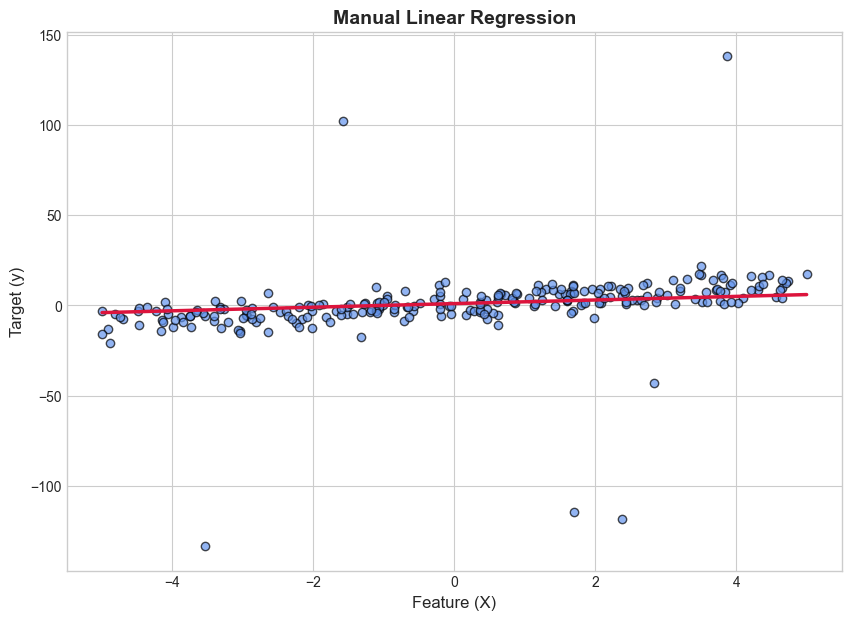

In [83]:
# Example of performing experiments
# f(x) = a*x + b
# ! For additional task !: f(x) = a*sin(b * log_2(x * c) + d) + e

lin_model_weights = [1, 1]
evaluate_regression_model(X_lin, y_lin, model=lin_model_weights, print_results=True)
plot_regression_model(X_lin, y_lin,
                      weights=[lin_model_weights[0], ],
                      intercept=lin_model_weights[1],
                      title='Manual Linear Regression')

![img/1_1_test1.img](img/1_1_test1.png)
![](img/1_1_test2.png)


Дуже бруднить звіт, не буду для кожного вставляти повні скріншоти

### Висновок: Лінійна модель коректна для лінійних даних, але довільні коефіцієнти дають провальні метрики; після підбору коеф. методом найменших квадратів показники суттєво покращуються.

## 1.2.1 Tuning Linear Regression on non-linear data

In [72]:
# Generating data
X_nonlin, y_nonlin = generate_regression_data(
    n_samples=300,
    n_features=1,
    mode='nonlinear',
    noise=5.0,
    n_outliers=8,
    random_seed=STUDENT_NO,
    return_coef=False
)

----- 📈 Model Evaluation -----
MAE      71.2341
MSE    6670.9569
RMSE     81.6759
R2     -906.4807
-----------------------------


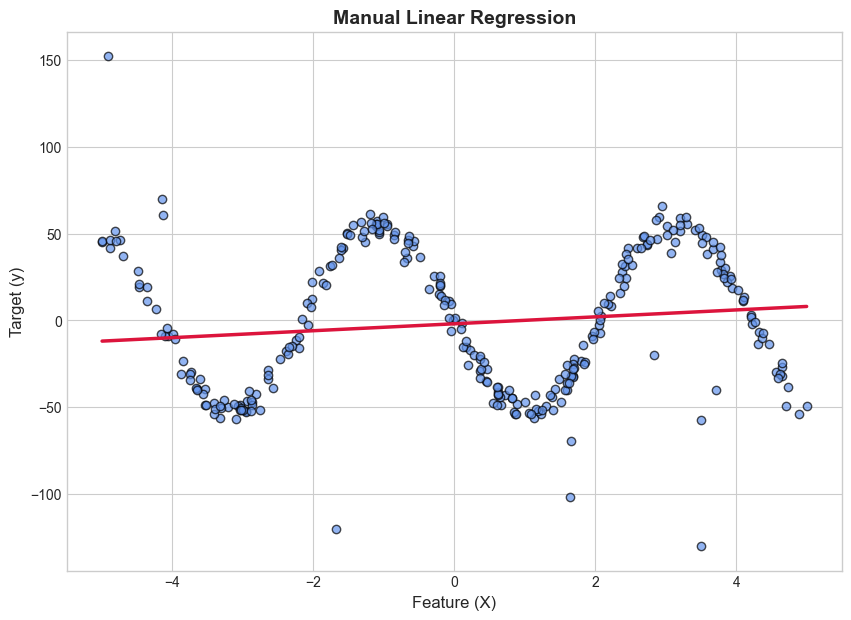

In [75]:
# Example of performing experiments
lin_model_weights = [2, -2]
evaluate_regression_model(X_nonlin, y_nonlin, model=lin_model_weights, print_results=True)
plot_regression_model(X_nonlin, y_nonlin,
                      weights=[lin_model_weights[0], ],
                      intercept=lin_model_weights[1],
                      title='Manual Linear Regression')

### Висновок: Для нелінійних (хвилястих) залежностей пряма систематично недомоделює (R² < 0, високий RMSE); потрібні нелінійні ознаки або моделі (SVR/RF/GB).

## 1.2.2 Manual Linear vs Sinusoidal data

----- 📈 Model Evaluation -----
MAE     15.1780
MSE    426.6077
RMSE    20.6545
R2     -57.0334
-----------------------------


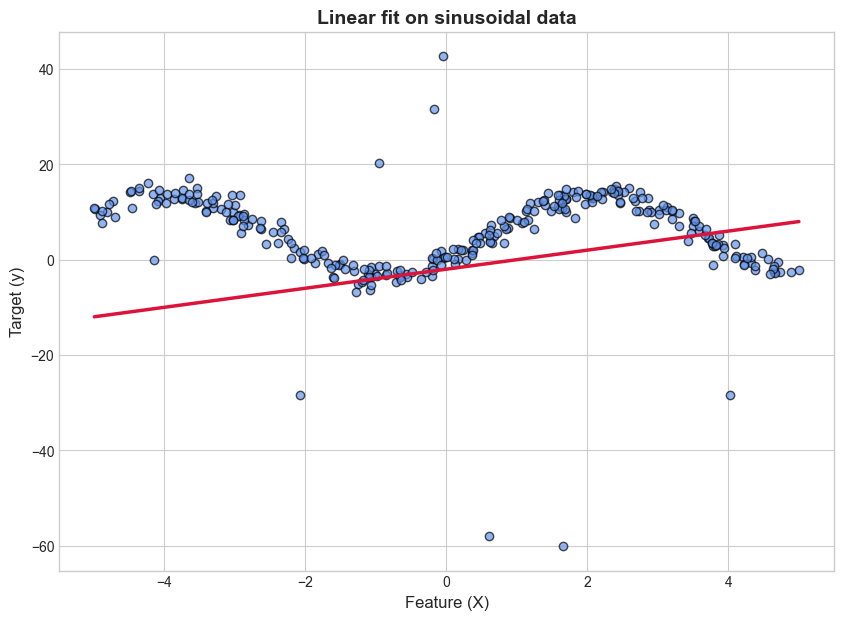

In [77]:
X_sin, y_sin = generate_regression_data(
    n_samples=300,
    n_features=1,
    mode='sin',
    noise=1.5,
    n_outliers=8,
    random_seed=STUDENT_NO
)

lin_w = [2, -2]  # linear to show underfitting
evaluate_regression_model(X_sin, y_sin, model=lin_w, print_results=True)
plot_regression_model(X_sin, y_sin, weights=[lin_w[0]], intercept=lin_w[1],
                      title="Linear fit on sinusoidal data")


### Висновок: Лінійна регресія усереднює синусоїду й не відтворює піки/пади, тому отримує великі помилки; адекватний підхід — синусоїдна параметризація або нелінійний алгоритм.

## 1.2.3 Manual Polynomial vs Cosine data

----- 📈 Model Evaluation -----
MAE        306.2779
MSE    4125684.7673
RMSE      2031.1782
R2     -561234.7413
-----------------------------


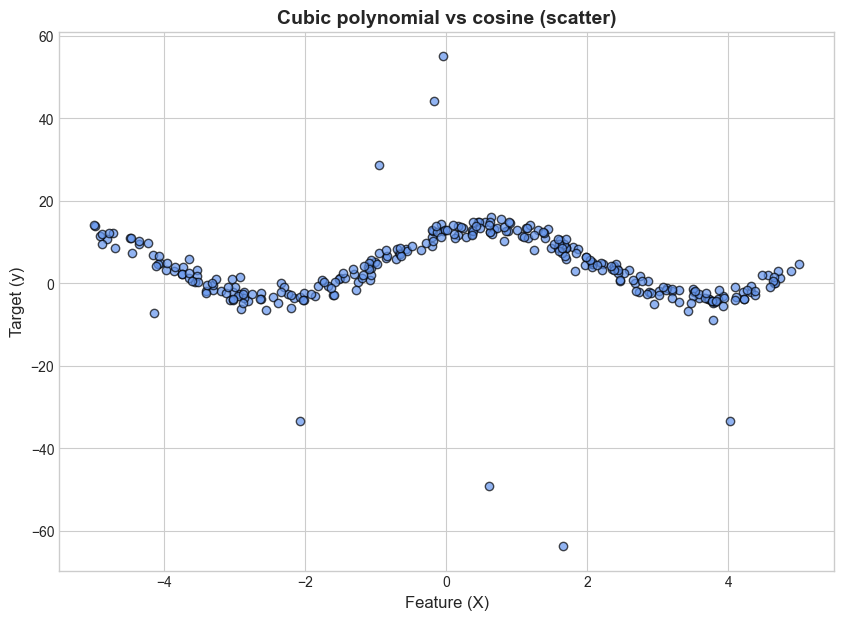

In [80]:
X_cos, y_cos = generate_regression_data(
    n_samples=300,
    n_features=1,
    mode='cos',
    noise=1.5,
    n_outliers=8,
    random_seed=STUDENT_NO
)

poly_w2 = [0.1, -0.2, 1.5, 0.0]  # cubic
evaluate_regression_model(X_cos, y_cos, model=poly_w2, print_results=True)
plot_regression_model(X_cos, y_cos, weights=None, intercept=None,
                      title="Cubic polynomial vs cosine (scatter)")

### Висновок: Кубічний поліном не є періодичним і «вистрілює» на краях діапазону, що спричиняє катастрофічний RMSE і дуже негативний R²; для косинусної структури потрібні тригонометричні базиси або ядрові/ансамблеві методи.

## 1.2.4 Manual models vs COMBO data (sin(log2) + poly tail) — hardest

Linear on combo:
----- 📈 Model Evaluation -----
MAE      23.9966
MSE    1088.5536
RMSE     32.9932
R2     -143.4496
-----------------------------
Cubic on combo:
----- 📈 Model Evaluation -----
MAE        255.9300
MSE    3420513.2276
RMSE      1849.4630
R2     -453896.4720
-----------------------------


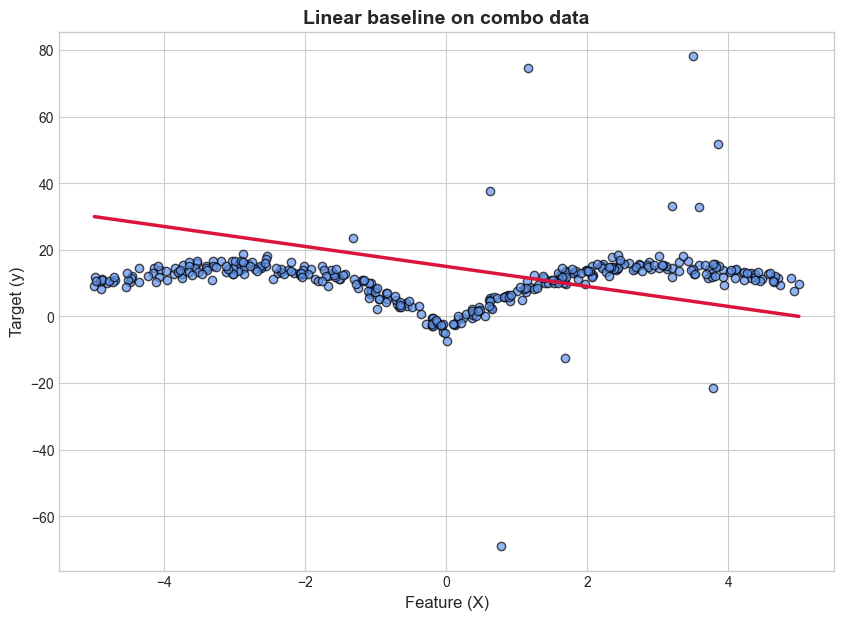

In [87]:
X_combo, y_combo = generate_regression_data(
    n_samples=350,
    n_features=1,
    mode='combo',
    noise=1.5,
    n_outliers=10,
    random_seed=STUDENT_NO
)

lin_w2 = [-3.0, 15.0]
poly_w3 = [0.05, -0.4, 2.0, -8.0]  # cubic

print("Linear on combo:")
evaluate_regression_model(X_combo, y_combo, model=lin_w2, print_results=True)

print("Cubic on combo:")
evaluate_regression_model(X_combo, y_combo, model=poly_w3, print_results=True)

plot_regression_model(X_combo, y_combo, weights=[lin_w2[0]], intercept=lin_w2[1],
                      title="Linear baseline on combo data")

### Висновок: Лінійна модель дає стабільний, але слабкий базовий рівень (R² < 0), тоді як поліном різко деградує через крайові ефекти; найкраща стратегія — інженерія ознак (логарифм + синус) або гнучкі моделі (SVR(RBF)/HistGB).

## 1.3. Configuring various linear models from sklearn library

configuring hyperparameters of various linear regression models from sklearn

In [ ]:
from sklearn.linear_model import LinearRegression, HuberRegressor, PoissonRegressor

### 1.3.0. LinearRegression baseline for comparing

----- 📈 Model Evaluation -----
MAE      6.5713
MSE    326.4932
RMSE    18.0691
R2       0.0974
-----------------------------


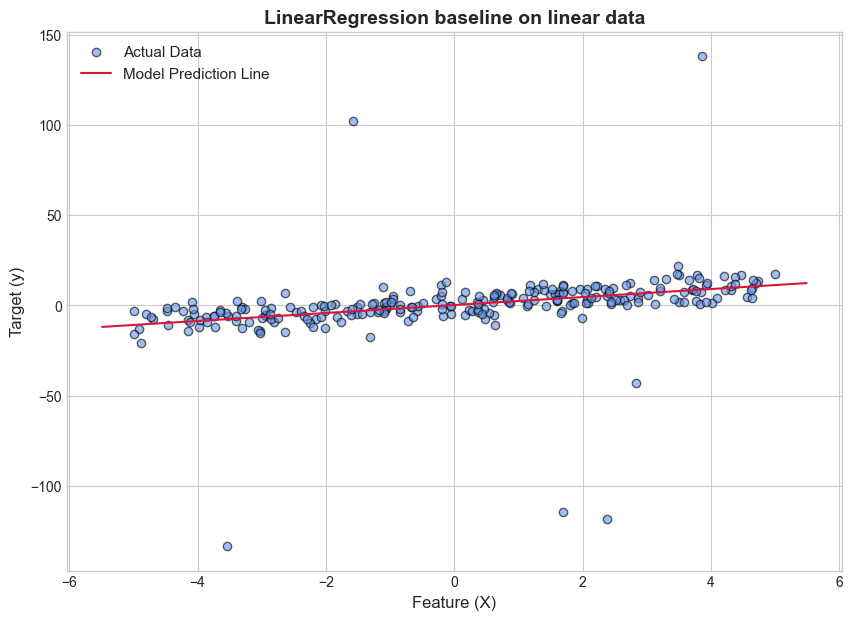

In [88]:
lin_base = LinearRegression()
lin_base.fit(X_lin, y_lin)

# evaluate() in your helper expects (y_true, X, model)
evaluate_regression_model(y_lin, X_lin, model=lin_base, print_results=True)

# plot: your helper expects an sklearn model
plot_sklearn_regression(lin_base, X_lin.reshape(-1, 1), y_lin,
                        title="LinearRegression baseline on linear data")